## Get the Data

Download data directly from kaggle following the discussion here https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198299

In [ ]:
# https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198299

In [ ]:
!pip uninstall -y kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10


In [ ]:
!pip install kaggle

     |████████████████████████████████| 61kB 5.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=6f5d1c719ac83766a8a406a156de515c22dd8484982cbdfdc206b0386632350a
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle


In [ ]:
import os

os.environ["KAGGLE_USERNAME"] = ''
os.environ["KAGGLE_KEY"] = ''

In [ ]:
# Download the data from the kaggle competition

raw_data_dir = "input/raw"

!kaggle competitions download -c cassava-leaf-disease-classification -p {raw_data_dir}

100% 5.75G/5.76G [02:06<00:00, 68.0MB/s]
100% 5.76G/5.76G [02:06<00:00, 49.0MB/s]


In [ ]:
# Check that the zip file was downloaded
!ls {raw_data_dir}

cassava-leaf-disease-classification.zip


In [ ]:
# Fuze-zip allows us to access zipped folders without
# first unzipping them. This is helpful when working
# with large files.

!apt-get install -y fuse-zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libzip4
The following NEW packages will be installed:
  fuse-zip libzip4
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 65.6 kB of archives.
After this operation, 178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libzip4 amd64 1.1.2-1.1 [37.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fuse-zip amd64 0.4.4-1 [27.9 kB]
Fetched 65.6 kB in 1s (109 kB/s)
Selecting previously unselected package libzip4:amd64.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../libzip4_1.1.2-1.1_amd64.deb ...
Unpacking libzip4:amd64 (1.1.2-1.1) ...
Selecting previously unselected package fuse-zip.
Preparing to unpack .../fuse-zip_0.4.4-1_amd64.deb ...
Unpacking fuse-zip (0.4.4-1) ...
Setting up libzip4:amd64 (1

In [ ]:
# Apply fuze-zip to the  data

input_dir = "/content/input/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/cassava-leaf-disease-classification.zip {input_dir}

In [ ]:
# Check that everything is working.
!ls {input_dir}

label_num_to_disease_map.json  test_images     train.csv     train_tfrecords
sample_submission.csv	       test_tfrecords  train_images


In [ ]:
# Use this path to access the downloaded folders

base_path = '/content/input/kaggle-data/'

os.listdir(base_path)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

## Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# reading train data
df = pd.read_csv(os.path.join(base_path,'train.csv'))
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
# replacing the label values with names
label = {0:'CBB', 1:'CBSD', 2:'CGM', 3:'CMD', 4:'Healthy'}
df['label'] = df.label.map(label)
df.head()

,image_id,label
0,1000015157.jpg,CBB
1,1000201771.jpg,CMD
2,100042118.jpg,CBSD
3,1000723321.jpg,CBSD
4,1000812911.jpg,CMD


In [ ]:
# train test split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.3, stratify = df['label'], random_state = 0)

In [ ]:
df_train.shape,  df_test.shape

((14977, 2), (6420, 2))

### Creating data genrators

In [ ]:
#!pip uninstall tensorflow-gpu

In [ ]:
!nvidia-smi

Fri Jan 15 09:44:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
print(tf.__version__)

2.4.0


In [ ]:
# data generator for visualizing
vis_data_gen = ImageDataGenerator(rotation_range=45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest',
                                   height_shift_range = 0.2,
                                   width_shift_range = 0.2,
                                   #preprocessing_function = preprocess_input
                                    )

In [ ]:
# train data generator
train_data_gen = ImageDataGenerator(rotation_range=45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest',
                                   height_shift_range = 0.2,
                                   width_shift_range = 0.2,
                                   preprocessing_function = preprocess_input
                                    )


In [ ]:
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

**Reading data using the generators**

In [ ]:
Batch_size = 16
Target_size = (380,380)

In [ ]:
vis_data = vis_data_gen.flow_from_dataframe(dataframe=df_train,
                                                directory='/content/input/kaggle-data/train_images',
                                                x_col = 'image_id', y_col = 'label',
                                                target_size = (334,334), batch_size = Batch_size,
                                                class_mode = 'categorical',shuffle = True, color_mode = 'rgb')

Found 14977 validated image filenames belonging to 5 classes.


In [ ]:
train_data = train_data_gen.flow_from_dataframe(dataframe=df_train,
                                                directory='/content/input/kaggle-data/train_images',
                                                x_col = 'image_id', y_col = 'label',
                                                target_size = Target_size, batch_size = Batch_size,
                                                class_mode = 'categorical',shuffle = True, color_mode = 'rgb', seed =99)

Found 14977 validated image filenames belonging to 5 classes.


In [ ]:
test_data = test_data_gen.flow_from_dataframe(dataframe=df_test,
                                                directory='/content/input/kaggle-data/train_images',
                                                x_col = 'image_id', y_col = 'label',
                                                target_size = Target_size,batch_size = Batch_size,
                                                class_mode = 'categorical', shuffle = True,color_mode = 'rgb', seed = 99)

Found 6420 validated image filenames belonging to 5 classes.


**Visualize data**

In [ ]:
def show_batch(image_batch, label_batch):
    CLASS_NAMES = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
    plt.figure(figsize=(15,10))
    for n in range(16):
        ax = plt.subplot(4,5,n+1)
        plt.imshow(image_batch[n].astype('uint8'))
        plt.title(CLASS_NAMES[np.argmax(label_batch[n])])
        plt.axis('off')

    return plt.show()

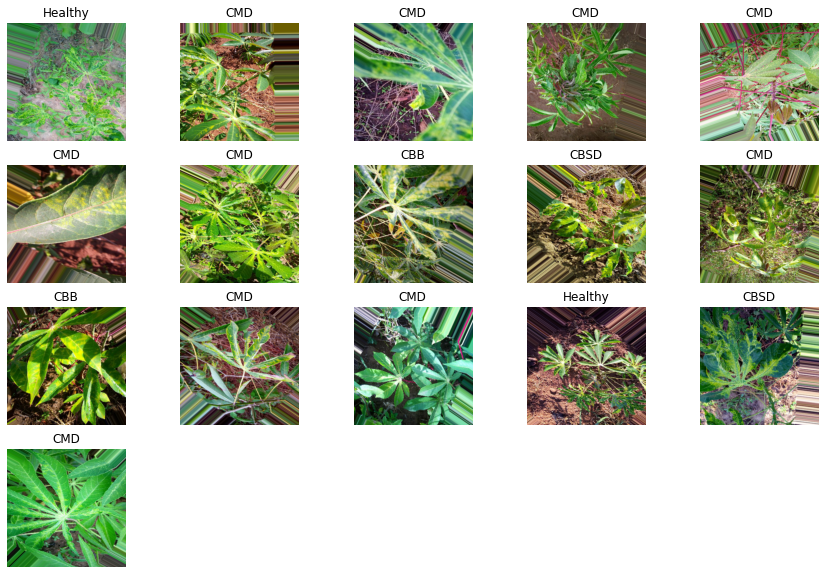

In [ ]:
image_batch = next(iter(vis_data))[0]
label_batch = next(iter(vis_data))[1]
show_batch(image_batch, label_batch)

**Converting data to tensoflow.data object**

In [ ]:
# checking the type and shape of the data

images,labels = next(train_data)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (16, 380, 380, 3)
float32 (16, 5)


In [ ]:
# create tensorflow.data
ds_train = tf.data.Dataset.from_generator(lambda:train_data,
                                          output_types = (tf.float32, tf.float32),
                                          output_shapes = ([None, 380, 380, 3],[None,5]))

In [ ]:
ds_train.cache()
ds_train.batch(batch_size=16)
ds_train.prefetch(buffer_size=1000)

<PrefetchDataset shapes: ((None, 380, 380, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [ ]:
ds_test = tf.data.Dataset.from_generator(lambda:test_data,
                                          output_types = (tf.float32, tf.float32),
                                          output_shapes = ([None, 380, 380, 3],[None,5]))

In [ ]:
ds_test.batch(batch_size=16)
ds_test.prefetch(buffer_size=1000)

<PrefetchDataset shapes: ((None, 380, 380, 3), (None, 5)), types: (tf.float32, tf.float32)>

### Modeling with Transfer learning using Resnet50

In [ ]:
# load the resnet50 model
basemodel = ResNet50(weights="imagenet", include_top=False,input_shape=Target_size+(3,), pooling='avg')


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# freeze all the layers of the basemodel
basemodel.trainable = False
#basemodel.summary()

In [ ]:
# adding output layer
num_classes = 5
output_layer = tf.keras.layers.Dense(500, activation = 'relu')(basemodel.output)
output_layer = tf.keras.layers.Dense(num_classes, activation = 'softmax')(output_layer)

In [ ]:
# creating the model by combining base model and output layer
model = tf.keras.Model(basemodel.input, output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 386, 386, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 190, 190, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 190, 190, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

**Compiling the model**

In [ ]:
STEPS_PER_EPOCH = len(df_train) // Batch_size
VALIDATION_STEPS = len(df_test) // Batch_size
EPOCHS = 20



In [ ]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
model_save = ModelCheckpoint('best_weights.h5',
                             save_best_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                              patience = 2, min_lr = 1e-6,
                              mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 4, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(ds_train, validation_data=ds_test,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS,callbacks =[model_save, reduce_lr, early_stop])

Epoch 1/20
936/936 [==============================] - 789s 833ms/step - loss: 0.8840 - accuracy: 0.6795 - val_loss: 0.7542 - val_accuracy: 0.7304

Epoch 00001: val_loss improved from inf to 0.75422, saving model to best_weights.h5
Epoch 2/20
936/936 [==============================] - 756s 808ms/step - loss: 0.7001 - accuracy: 0.7500 - val_loss: 0.6080 - val_accuracy: 0.7789

Epoch 00002: val_loss improved from 0.75422 to 0.60803, saving model to best_weights.h5
Epoch 3/20
936/936 [==============================] - 755s 807ms/step - loss: 0.6395 - accuracy: 0.7632 - val_loss: 0.6376 - val_accuracy: 0.7720

Epoch 00003: val_loss did not improve from 0.60803
Epoch 4/20
936/936 [==============================] - 763s 815ms/step - loss: 0.5994 - accuracy: 0.7791 - val_loss: 0.5764 - val_accuracy: 0.7954

Epoch 00004: val_loss improved from 0.60803 to 0.57642, saving model to best_weights.h5
Epoch 5/20
936/936 [==============================] - 750s 802ms/step - loss: 0.5941 - accuracy: 0.78

In [ ]:
# Evaluation on test set
#loss, acc = model.evaluate_generator(ds_test)

### Fine Tuning

**unfreezinf few top layers of the model**

In [ ]:
basemodel.trainable = True

In [ ]:
# finding number of layers in the basemodel
print(f'Number of layers in the base model: {len(basemodel.layers)}')

Number of layers in the base model: 176


In [ ]:
# Training only layers above 120
fine_tune_at = 120
for layer in basemodel.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(ds_train, validation_data=ds_test,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=10,
          callbacks =[model_save, reduce_lr, early_stop])

Epoch 1/10
936/936 [==============================] - 812s 865ms/step - loss: 0.7101 - accuracy: 0.7543 - val_loss: 0.7511 - val_accuracy: 0.7488

Epoch 00001: val_loss did not improve from 0.57642
Epoch 2/10
936/936 [==============================] - 820s 876ms/step - loss: 0.4980 - accuracy: 0.8300 - val_loss: 0.5269 - val_accuracy: 0.8226

Epoch 00002: val_loss improved from 0.57642 to 0.52690, saving model to best_weights.h5
Epoch 3/10
936/936 [==============================] - 804s 860ms/step - loss: 0.4709 - accuracy: 0.8346 - val_loss: 0.4891 - val_accuracy: 0.8395

Epoch 00003: val_loss improved from 0.52690 to 0.48906, saving model to best_weights.h5
Epoch 4/10
936/936 [==============================] - 807s 863ms/step - loss: 0.4129 - accuracy: 0.8574 - val_loss: 0.4442 - val_accuracy: 0.8429

Epoch 00004: val_loss improved from 0.48906 to 0.44415, saving model to best_weights.h5
Epoch 5/10
936/936 [==============================] - 812s 868ms/step - loss: 0.4088 - accuracy: 

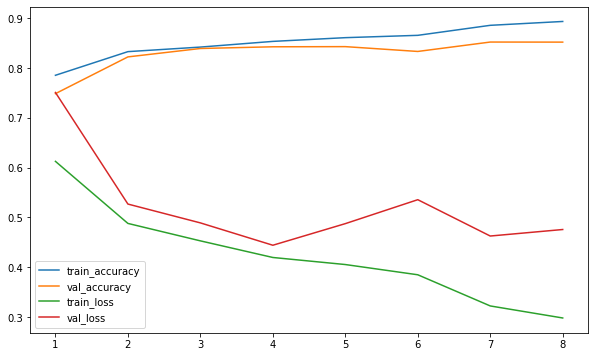

In [ ]:
train_history = model.history.history
train_epochs = len(train_history['accuracy'])

plt.figure(figsize=(10,6))
plt.plot(range(1,train_epochs+1), train_history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,train_epochs+1), train_history['val_accuracy'], label = 'val_accuracy')

plt.plot(range(1,train_epochs+1), train_history['loss'], label = 'train_loss')
plt.plot(range(1,train_epochs+1), train_history['val_loss'], label = 'val_loss')

plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Computer vision/tf_model.h5')

In [ ]:
# load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Computer vision/tf_model.h5')

In [ ]:
# Evaluate on the test data

In [ ]:
loss, accuracy = model.evaluate(test_data, batch_size=32)
print(f'Accuracy on test data: {np.round(accuracy,3)}')


Accuracy on test data: 0.843
